In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = 'online_retail_II.xlsx'

In [2]:
df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
print(df_2009.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [15]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df_2009.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
df_2009.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

## Data Cleaning

In [3]:
# Data Cleaning for 2009-2010 Data
df = df_2009.copy()

# Remove rows with missing Customer ID or Description
df = df.dropna(subset=['Customer ID', 'Description'])

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0 ) & (df['Price'] > 0)]
df['Invoice'] = df['Invoice'].astype(str)

# Remove canceled orders (Invoice starting with 'C')
df = df[~df['Invoice'].str.startswith('C')]

# Create Total Sales column
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove duplicate rows
df = df.drop_duplicates()

# Convert Customer ID to integer
df['Customer ID'] = df['Customer ID'].astype(int)

## Activity-Based Retention

In [4]:
df = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate', 'Country'], as_index=False).agg({'TotalSales': 'sum'})
df = df.sort_values(['Customer ID', 'InvoiceDate'])

df['PrevInvoiceDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(1)
df['DaysBetween'] = (df['InvoiceDate'] - df['PrevInvoiceDate']).dt.days
df.head()

,Invoice,Customer ID,InvoiceDate,Country,TotalSales,PrevInvoiceDate,DaysBetween
1006,491725,12346,2009-12-14 08:34:00,United Kingdom,45.0,NaT,NaN
1017,491742,12346,2009-12-14 11:00:00,United Kingdom,22.5,2009-12-14 08:34:00,0.0
1019,491744,12346,2009-12-14 11:02:00,United Kingdom,22.5,2009-12-14 11:00:00,0.0
1361,492718,12346,2009-12-18 10:47:00,United Kingdom,22.5,2009-12-14 11:02:00,3.0
1363,492722,12346,2009-12-18 10:55:00,United Kingdom,1.0,2009-12-18 10:47:00,0.0


## Days between Purchases Histogram

Text(0.5, 1.0, 'Histogram of Days Between Purchases')

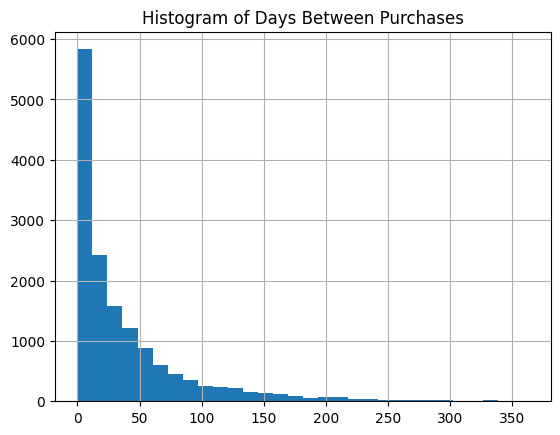

In [5]:
histogram = df['DaysBetween'].hist(bins=30)
histogram.set_title('Histogram of Days Between Purchases')

## Last Purchase and Determining Churn

In [6]:
reference_date = df['InvoiceDate'].max()

last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
last_purchase['days_since_last_purchase'] = (reference_date - last_purchase['InvoiceDate']).dt.days
last_purchase['Churned'] = last_purchase['days_since_last_purchase'] > 180

## Churned vs Active Customers Analysis

In [7]:
customer_metrics = df.groupby('Customer ID').agg(
    total_revenue=('TotalSales', 'sum'),
    num_orders=('Invoice', 'nunique'),
    avg_order_value=('TotalSales', 'mean'),
    first_purchse=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
)
customer_metrics['tenure_days'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchse']).dt.days
customer_metrics = customer_metrics.merge(last_purchase[['Customer ID', 'days_since_last_purchase', 'Churned']], on='Customer ID')
customer_metrics

,Customer ID,total_revenue,num_orders,avg_order_value,first_purchse,last_purchase,tenure_days,days_since_last_purchase,Churned
0,12346,372.86,11,33.896364,2009-12-14 08:34:00,2010-06-28 13:53:00,196,164,False
1,12347,1323.32,2,661.660000,2010-10-31 14:20:00,2010-12-07 14:57:00,37,2,False
2,12348,222.16,1,222.160000,2010-09-27 14:59:00,2010-09-27 14:59:00,0,73,False
3,12349,2671.14,3,890.380000,2010-04-29 13:20:00,2010-10-28 08:23:00,181,42,False
4,12351,300.93,1,300.930000,2010-11-29 15:23:00,2010-11-29 15:23:00,0,10,False
...,...,...,...,...,...,...,...,...,...
4307,18283,619.37,6,103.228333,2010-02-19 17:16:00,2010-11-22 15:30:00,275,17,False
4308,18284,461.68,1,461.680000,2010-10-04 11:33:00,2010-10-04 11:33:00,0,66,False
4309,18285,427.00,1,427.000000,2010-02-17 10:24:00,2010-02-17 10:24:00,0,295,True
4310,18286,1296.43,2,648.215000,2009-12-16 10:45:00,2010-08-20 11:57:00,247,111,False


## Building Prediction Features

In [8]:
prediction_features = df.groupby('Customer ID').agg(
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max'),
    avg_days_between=('DaysBetween', 'mean'),
    purchase_frequency=('Invoice', 'nunique')
)
prediction_features['tenure_days'] = (prediction_features['last_purchase'] - prediction_features['first_purchase']).dt.days
prediction_features = prediction_features.merge(last_purchase[['Customer ID', 'Churned']], on='Customer ID')
prediction_features = prediction_features[prediction_features['first_purchase'] < '2010-06-30'].reset_index(drop=True)
prediction_features.drop(columns=['Customer ID', 'first_purchase'], inplace=True)
prediction_features


,last_purchase,avg_days_between,purchase_frequency,tenure_days,Churned
0,2010-06-28 13:53:00,19.200000,11,196,False
1,2010-10-28 08:23:00,90.000000,3,181,False
2,2010-05-21 11:59:00,NaN,1,0,True
3,2010-11-29 10:56:00,177.500000,3,356,False
4,2010-10-10 11:16:00,61.400000,6,308,False
...,...,...,...,...,...
2956,2010-05-11 10:49:00,NaN,1,0,True
2957,2010-11-22 15:30:00,54.600000,6,275,False
2958,2010-02-17 10:24:00,NaN,1,0,True
2959,2010-08-20 11:57:00,247.000000,2,247,False


In [9]:
prediction_features['Churned'].value_counts()

Churned
False    2136
True      825
Name: count, dtype: int64

## Data Sanity Check

In [10]:
# Check class balance
prediction_features['Churned'].value_counts(normalize=True)

Churned
False    0.721378
True     0.278622
Name: proportion, dtype: float64

In [11]:
# Check NaN patterns, NaNs only appear in avg_days_between when pruchase_frequency is 1
prediction_features[['avg_days_between', 'purchase_frequency', 'tenure_days']].isna().mean()
assert(prediction_features[prediction_features['avg_days_between'].isna() == True]['purchase_frequency']==1).all()

In [12]:
# Validate feature ranges
prediction_features.describe()

,last_purchase,avg_days_between,purchase_frequency,tenure_days
count,2961,2335.000000,2961.000000,2961.000000
mean,2010-08-22 08:02:54.934143744,78.340448,5.636272,184.794326
min,2009-12-01 09:55:00,0.000000,1.000000,0.000000
25%,2010-05-27 20:31:00,35.100000,2.000000,47.000000
50%,2010-10-08 14:44:00,59.400000,3.000000,204.000000
75%,2010-11-21 12:11:00,100.333333,6.000000,300.000000
max,2010-12-09 20:01:00,361.000000,205.000000,373.000000
std,NaN,64.450819,9.571023,129.552204


## Visualization of Features

In [13]:
prediction_features.groupby('Churned')[['avg_days_between', 'purchase_frequency', 'tenure_days']].median()

,avg_days_between,purchase_frequency,tenure_days
Churned,,,
False,61.200000,5.0,255.0
True,41.666667,1.0,0.0


## Handling NaN before Modeling

In [14]:
prediction_features['avg_days_between'] = prediction_features['avg_days_between'].fillna(999)

## Building Predictive Model

In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(prediction_features, test_size=0.2, random_state=42, stratify=prediction_features['Churned'])

X_train = np.array(train_data)[:, 2:4]
y_train = np.array(train_data)[:, -1].astype(int)
X_test = np.array(test_data)[:, 2:4]
y_test = np.array(test_data)[:, -1].astype(int)

In [36]:
X_train

array([[8, 135],
       [4, 281],
       [11, 358],
       ...,
       [1, 0],
       [5, 241],
       [5, 313]], shape=(2368, 2), dtype=object)

In [16]:
train_data['Churned'].value_counts(normalize=True), test_data['Churned'].value_counts(normalize=True)

(Churned
 False    0.721284
 True     0.278716
 Name: proportion, dtype: float64,
 Churned
 False    0.721754
 True     0.278246
 Name: proportion, dtype: float64)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
train_accuracy, test_accuracy

(0.918918918918919, 0.9409780775716695)

## Plotting the data and the Logistic Line

In [19]:
model.intercept_[0], model.coef_[0][0], model.coef_[0][1]

(np.float64(-2.8020968579849534),
 np.float64(0.08460774737063391),
 np.float64(-3.610238782691847))

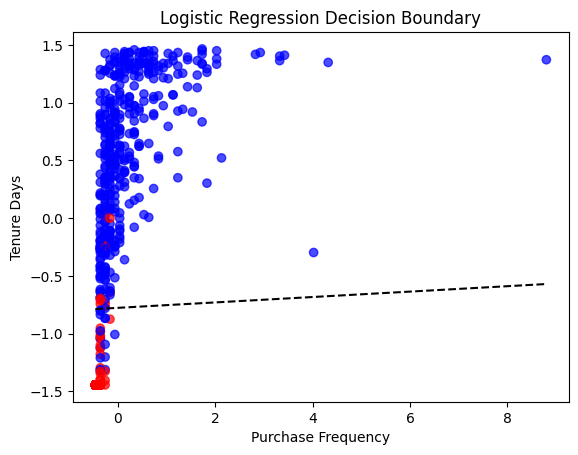

In [39]:
w1, w2 = model.coef_[0]
b = model.intercept_[0]

x_vales = np.linspace(X_test_scaled[:,0].min(), X_test_scaled[:,0].max(), 100)
y_values = -(w1 * x_vales + b) / w2

plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap='bwr', alpha=0.7)
plt.plot(x_vales, y_values, color='black', linestyle='--')
plt.xlabel('Purchase Frequency')
plt.ylabel('Tenure Days')
plt.title('Logistic Regression Decision Boundary')
plt.show()